In [47]:
import numpy as np
import pandas as pd
import scipy, scipy.stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import itertools

## Daten einlesen

In [2]:
data = pd.read_csv("data/housing.csv", sep=",") #Datensatz zum Testen der Vorhersage 

In [3]:
pd.DataFrame(data).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Kurzer Überblick

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
##Bei Total Bedrooms sind nicht alle Zeilen ausgefüllt, deshalb werfen wir sie später raus

In [6]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
corr_matrix=data.corr()
corr_matrix["median_house_value"]

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

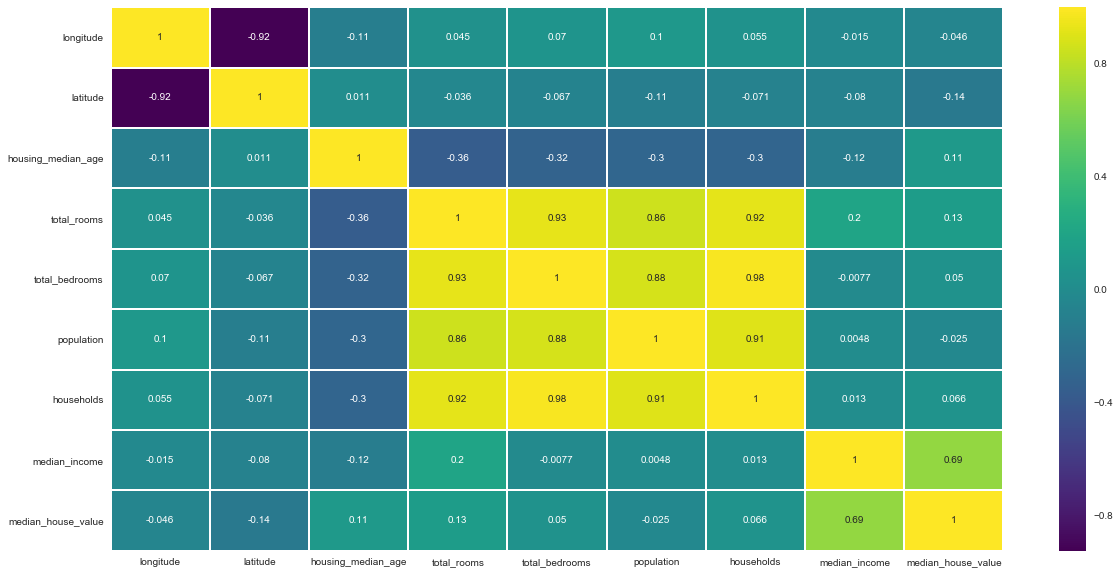

In [8]:
corr_matrix = data.corr()

plt.subplots(figsize=(20,10))

sns.heatmap(corr_matrix, annot=True, linewidths=1, cmap='viridis');

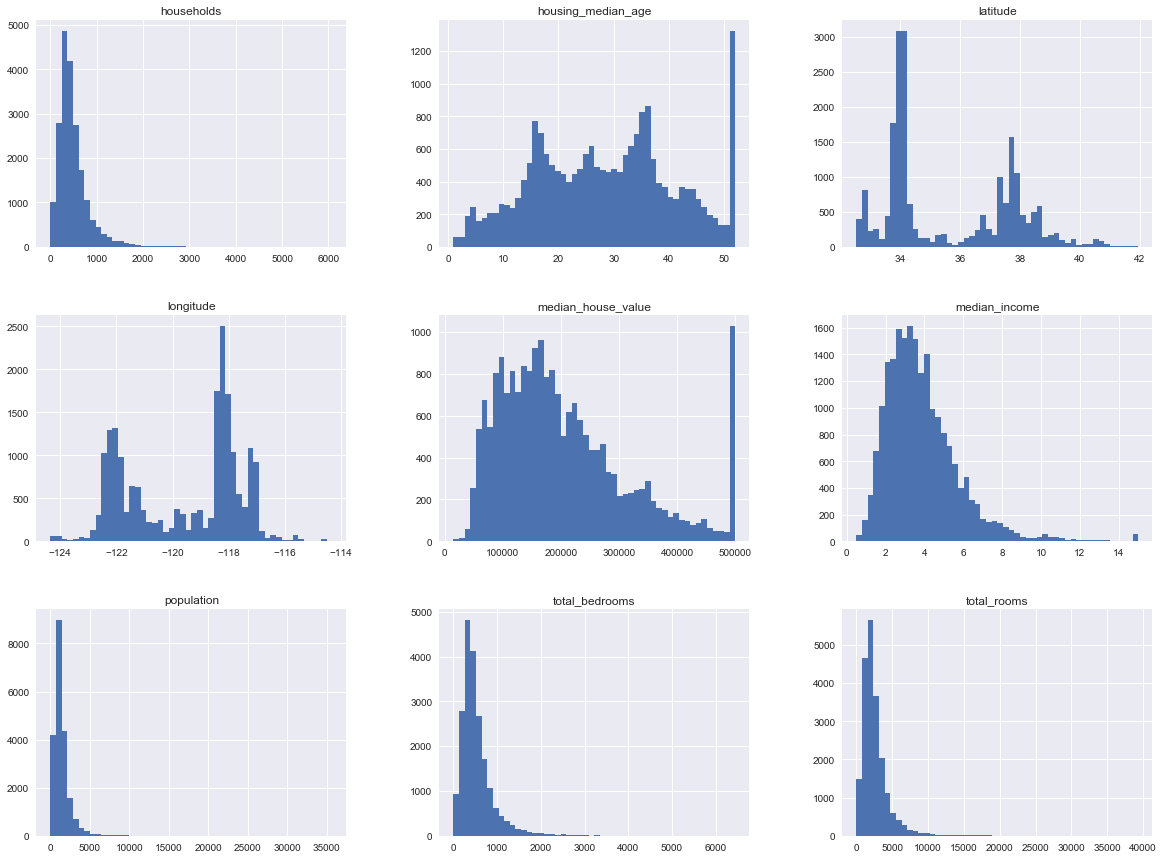

In [9]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
#sns.pairplot(data, hue="ocean_proximity")

In [11]:
data["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

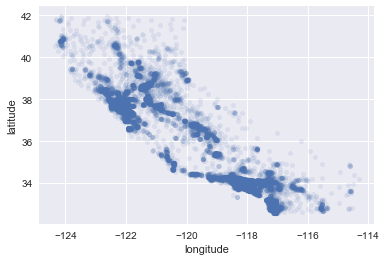

In [12]:
data.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)

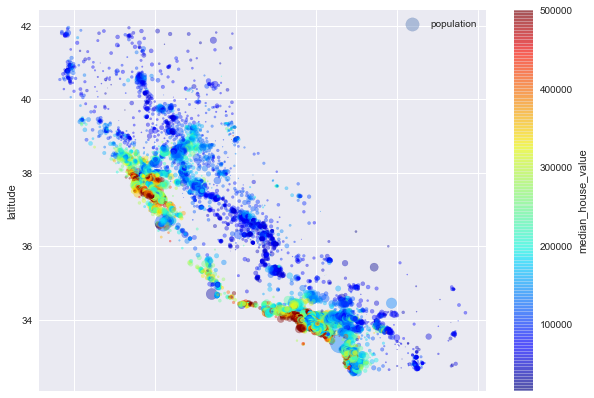

In [13]:
data.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
                s=data["population"]/100,label="population",figsize=(10,7),
                c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True,
)
plt.legend()

## Daten aufbereiten für ML 

### Umgang mit null-Werten

In [14]:
# Auffällig ist die Anzahl der Zeilen bei dem Label "total_bedrooms".
#Total_bedrooms mit den Einträgen NaN können von ML nicht gelesen werden
#Daher:

# Option 1: drop all rows with null
# Option 2: drop complete column : housing.drop("total_bedrooms", axis=1) 
#Option 3: ACHTUNG: darf man erst bei den Trainingsdatendurchführen 
#train_set["total_bedrooms"].fillna(train_set["total_bedrooms"].mean(),inplace = True)

### Einführen neuer Paramter

In [15]:
#zb. Bedrooms per room, population_per_household

### Auswählen der Input-Daten

In [16]:
def getinputdata (*,population_per_household=False, bedrooms_per_room=False,longitude=False,latitude=False,housing_median_age=False,total_bedrooms=False,total_rooms=False,population=False,households=False,median_income=False,ocean_proximity=False,nulloption):
    data2 = pd.DataFrame()
    data2["median_house_value"]=data["median_house_value"]
    if population_per_household:
        data2["population_per_household"]=data["population"]/data["households"]
    if bedrooms_per_room:
        data2["bedrooms_per_room"]=data["total_bedrooms"]/data["total_rooms"]
    if longitude:
        data2["longitude"] = data["longitude"]
    if latitude:
        data2["latitude"]= data["latitude"]
    if housing_median_age:
        data2["housing_median_age"]= data["housing_median_age"]
    if total_bedrooms:
        data2["total_bedrooms"]= data["total_bedrooms"]
    if total_rooms:
        data2["total_rooms"]= data["total_rooms"]
    if population:
        data2["population"] = data["population"]    
    if households:
        data2["households"]= data["households"]
    if median_income:
        data2["median_income"]= data["median_income"]
    if ocean_proximity:
        #hier wird das kategorische Merkmal verarbeitet
        cat_encoded,categories= data["ocean_proximity"].factorize()
        enc = OneHotEncoder()
        cat1hot=enc.fit_transform(cat_encoded.reshape(-1,1))
        cat1hot_array= cat1hot.toarray()
        category_df = pd.DataFrame(data = cat1hot_array, columns = list(categories))
        data2 = pd.concat([data2,category_df],axis=1)
    if nulloption == "droprows":
        data2=data2.dropna(axis=0, how='any')
    elif nulloption == "dropcolumns":
        data2=data2.dropna(axis=1, how='any')
    return data2

housing_cat_encoded,housing_categories=data["ocean_proximity"].factorize()
enc = OneHotEncoder()
housing_cat1hot=enc.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat1hot_array= housing_cat1hot.toarray()
new_ocean_df = pd.DataFrame(data = housing_cat1hot_array, columns = list(housing_categories))

data_new = pd.concat([data,new_ocean_df],axis=1)
data_new.drop("ocean_proximity",axis = 1,inplace = True)
data_new.head()

### Erstellen der Datensätze für verschiedene Ansätze

In [17]:
#population_per_household, bedrooms_per_room,longitude,latitude,housing_median_age,total_bedrooms,
#total_rooms,population,households,median_income,ocean_proximity,nulloption)

Ansätze mit Löschen der Null-Zeilen

Ansatz0 = Einführen neuer Parameter

In [18]:
Ansatz0 = getinputdata(population_per_household=True, bedrooms_per_room=True,longitude=True,latitude=True,housing_median_age=True,median_income=True,ocean_proximity=True,nulloption="droprows")

In [19]:
Ansatz0.head()

,median_house_value,population_per_household,bedrooms_per_room,longitude,latitude,housing_median_age,median_income,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
0,452600.0,2.555556,0.146591,-122.23,37.88,41.0,8.3252,1.0,0.0,0.0,0.0,0.0
1,358500.0,2.109842,0.155797,-122.22,37.86,21.0,8.3014,1.0,0.0,0.0,0.0,0.0
2,352100.0,2.802260,0.129516,-122.24,37.85,52.0,7.2574,1.0,0.0,0.0,0.0,0.0
3,341300.0,2.547945,0.184458,-122.25,37.85,52.0,5.6431,1.0,0.0,0.0,0.0,0.0
4,342200.0,2.181467,0.172096,-122.25,37.85,52.0,3.8462,1.0,0.0,0.0,0.0,0.0


Ansatz1 = Neue Parameter (population_per_household, bedrooms_per_room), median_income,longitude,latitude

In [20]:
Ansatz1 = getinputdata (population_per_household=True,bedrooms_per_room=True,median_income=True,longitude=True,latitude=True,nulloption="droprows")

In [21]:
Ansatz1.head()

,median_house_value,population_per_household,bedrooms_per_room,longitude,latitude,median_income
0,452600.0,2.555556,0.146591,-122.23,37.88,8.3252
1,358500.0,2.109842,0.155797,-122.22,37.86,8.3014
2,352100.0,2.802260,0.129516,-122.24,37.85,7.2574
3,341300.0,2.547945,0.184458,-122.25,37.85,5.6431
4,342200.0,2.181467,0.172096,-122.25,37.85,3.8462


In [22]:
pd.DataFrame(Ansatz1).shape

(20433, 6)

Ansatz2 = Koordinaten und Income

In [23]:
Ansatz2 = getinputdata (longitude=True,latitude=True,median_income=True,nulloption="droprows")

In [24]:
Ansatz2.head()

,median_house_value,longitude,latitude,median_income
0,452600.0,-122.23,37.88,8.3252
1,358500.0,-122.22,37.86,8.3014
2,352100.0,-122.24,37.85,7.2574
3,341300.0,-122.25,37.85,5.6431
4,342200.0,-122.25,37.85,3.8462


Ansatz3 = Nur mit Income

In [25]:
Ansatz3= getinputdata (median_income=True,nulloption="droprows")

In [26]:
Ansatz3.head()

,median_house_value,median_income
0,452600.0,8.3252
1,358500.0,8.3014
2,352100.0,7.2574
3,341300.0,5.6431
4,342200.0,3.8462


Ansatz4= Nur mit Koordinaten 

In [27]:
Ansatz4= getinputdata (longitude=True,latitude=True,nulloption="droprows")

In [28]:
Ansatz4.head()

,median_house_value,longitude,latitude
0,452600.0,-122.23,37.88
1,358500.0,-122.22,37.86
2,352100.0,-122.24,37.85
3,341300.0,-122.25,37.85
4,342200.0,-122.25,37.85


Ansatz5= Income and Ocean Proximity

In [29]:
Ansatz5= getinputdata (median_income=True,ocean_proximity=True,nulloption="droprows")

In [30]:
Ansatz5.head()

,median_house_value,median_income,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
0,452600.0,8.3252,1.0,0.0,0.0,0.0,0.0
1,358500.0,8.3014,1.0,0.0,0.0,0.0,0.0
2,352100.0,7.2574,1.0,0.0,0.0,0.0,0.0
3,341300.0,5.6431,1.0,0.0,0.0,0.0,0.0
4,342200.0,3.8462,1.0,0.0,0.0,0.0,0.0


### Aufteilen in einen Trainings- und Testdatensatz/ Separieren des Targets/Skalierung

In [31]:
def traintest (data,scaling):
    train_set,test_set=train_test_split(data,test_size=0.2,random_state=42) ##aufteilen von test und train
    X_train = train_set.drop("median_house_value", axis=1) # Trainingsdaten ohne Target y "median_house_value"
    y_train = train_set["median_house_value"] # Trainingsdaten nur mit Target y "median_house_value"
    X_test = test_set.drop("median_house_value", axis=1) # Testdaten ohne Target y "median_house_value"
    y_test = test_set["median_house_value"] # Testdaten nur mit Target y "median_house_value"
    if scaling == "yes":
        columnstoscale=data.shape[-1]
        if data.columns[-1] == "ISLAND":
            columnstoscale=data.shape[-1]-5
        scaler = StandardScaler()
        scaler.fit(X_train.iloc[:,0:columnstoscale])
        X_train.iloc[:,0:columnstoscale] = scaler.transform(X_train.iloc[:,0:columnstoscale])
        X_test.iloc[:,0:columnstoscale] = scaler.transform(X_test.iloc[:,0:columnstoscale])
    return X_train,y_train,X_test,y_test

##doch nicht verwendet, da hier die Skalierung die Spaltenbezeichnung verliert!

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Durchführen der Models (Lineare Regression/KNR)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model

In [33]:
def executemodels (data,scaling,nameansatz):
    X_train,y_train,X_test,y_test = traintest(data,scaling)
    result = pd.DataFrame()
    y_test=y_test.rename(columns={'median_house_value': 'y_test'})
    y_test.reset_index(drop=True,inplace=True)
    result["y_test"]=y_test
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    # Make predictions using the training set
    result[nameansatz+"_LR"] = regr.predict(X_test)
    for i in range(3,11):
        model = KNeighborsRegressor(n_neighbors=i,weights='distance').fit(X_train, y_train.values) 
        result[nameansatz+"_KNR_"+"k"+str(i)] = model.predict(X_test)
    return result

In [34]:
ansätze={"Ansatz0": Ansatz0,"Ansatz1": Ansatz1,"Ansatz2": Ansatz2,"Ansatz3": Ansatz3,"Ansatz4": Ansatz4,"Ansatz5": Ansatz5}
results={}
for key,values in ansätze.items(): 
    results[key]= executemodels (values,"yes",key)

In [48]:
print(results)

{'Ansatz0':         y_test     Ansatz0_LR  Ansatz0_KNR_k3  Ansatz0_KNR_k4  Ansatz0_KNR_k5  \
0     245800.0  217690.395308   193757.921777   182559.038426   170383.010000   
1     137900.0  161915.574979   144300.498116   144322.471643   153366.874452   
2     218200.0  198097.885172   219875.862375   220005.791183   219110.903610   
3     220800.0  188403.344591   155270.851936   158797.081351   171017.331323   
4     170500.0  192137.862140   116058.189195   124787.108754   129063.513810   
5      75000.0  102563.955908    70252.365797    74082.261928    72064.430178   
6     269400.0  286746.234526   311722.999888   297483.962637   312198.590411   
7     228900.0  253824.167036   202564.859084   203085.031382   205990.786349   
8     500001.0  388657.639651   489032.311871   481670.848453   484631.885048   
9      80800.0   64936.861918    66901.962254    66030.128361    65696.000621   
10    170000.0  -19927.215113    91427.225149   101173.264209   106889.080141   
11     87800.0  

In [35]:
def calculatescores(data):
    r2=[]
    mse=[]
    rmse=[]
    setindex=["R2","Mittlere quadratische Abweichung (MSE)","Wurzel aus mq Abweichung(RMSE)"]
    setcolumns=data.columns.values.tolist()[1:]
    table = np.zeros((3,data.shape[1]-1))
    for j in range (1,data.shape[1]):
        y=data.iloc[:,0]
        ypre=data.iloc[:,j]
        score=r2_score(y, ypre).round(3)
        r2.append(score)
        score2=mean_squared_error(y,ypre)
        mse.append(score2)
        score3=np.sqrt(score2).round()
        rmse.append(score3)
    table[0,:]=r2
    table[1,:]=mse
    table[2,:]=rmse
    resulttable= pd.DataFrame(data=table,columns=setcolumns,index=setindex)
    return resulttable.T

In [36]:
scores={}
setcolumns=["R2","Mittlere quadratische Abweichung (MSE)","Wurzel aus mq Abweichung(RMSE)"]
allscores=pd.DataFrame(columns=setcolumns)
for key,values in results.items(): 
    scores[key]= calculatescores(values)
for key,values in scores.items():
    allscores = pd.concat([allscores, values])

In [37]:
scorestop3={}
setcolumns=["R2","Mittlere quadratische Abweichung (MSE)","Wurzel aus mq Abweichung(RMSE)"]
allscorestop3=pd.DataFrame(columns=setcolumns)
for key,values in results.items(): 
    scorestop3[key]= calculatescores(values).sort_values(by=['R2'],ascending=False).iloc[:3,:]
for key,values in scorestop3.items():
    allscorestop3 = pd.concat([allscorestop3, values])

In [38]:
allscorestop3

,R2,Mittlere quadratische Abweichung (MSE),Wurzel aus mq Abweichung(RMSE)
Ansatz0_KNR_k9,0.724,3.777291e+09,61460.0
Ansatz0_KNR_k10,0.724,3.775761e+09,61447.0
Ansatz0_KNR_k8,0.723,3.787301e+09,61541.0
Ansatz1_KNR_k9,0.737,3.600451e+09,60004.0
Ansatz1_KNR_k10,0.737,3.596793e+09,59973.0
Ansatz1_KNR_k7,0.736,3.608623e+09,60072.0
Ansatz2_KNR_k9,0.764,3.097019e+09,55651.0
Ansatz2_KNR_k7,0.763,3.109609e+09,55764.0
Ansatz2_KNR_k8,0.763,3.103470e+09,55709.0
Ansatz3_LR,0.459,7.091158e+09,84209.0


### Visualisieren der Ergebnisse

In [39]:
allscoressorted=allscores.sort_values(by=['R2'],ascending=False)

In [40]:
allscoressorted

,R2,Mittlere quadratische Abweichung (MSE),Wurzel aus mq Abweichung(RMSE)
Ansatz4_KNR_k8,0.779,2.892339e+09,53780.0
Ansatz4_KNR_k9,0.779,2.892934e+09,53786.0
Ansatz4_KNR_k6,0.779,2.901574e+09,53866.0
Ansatz4_KNR_k7,0.779,2.896318e+09,53817.0
Ansatz4_KNR_k10,0.778,2.912976e+09,53972.0
Ansatz4_KNR_k5,0.777,2.920830e+09,54045.0
Ansatz4_KNR_k4,0.775,2.946309e+09,54280.0
Ansatz4_KNR_k3,0.770,3.013598e+09,54896.0
Ansatz2_KNR_k9,0.764,3.097019e+09,55651.0
Ansatz2_KNR_k10,0.763,3.108151e+09,55751.0


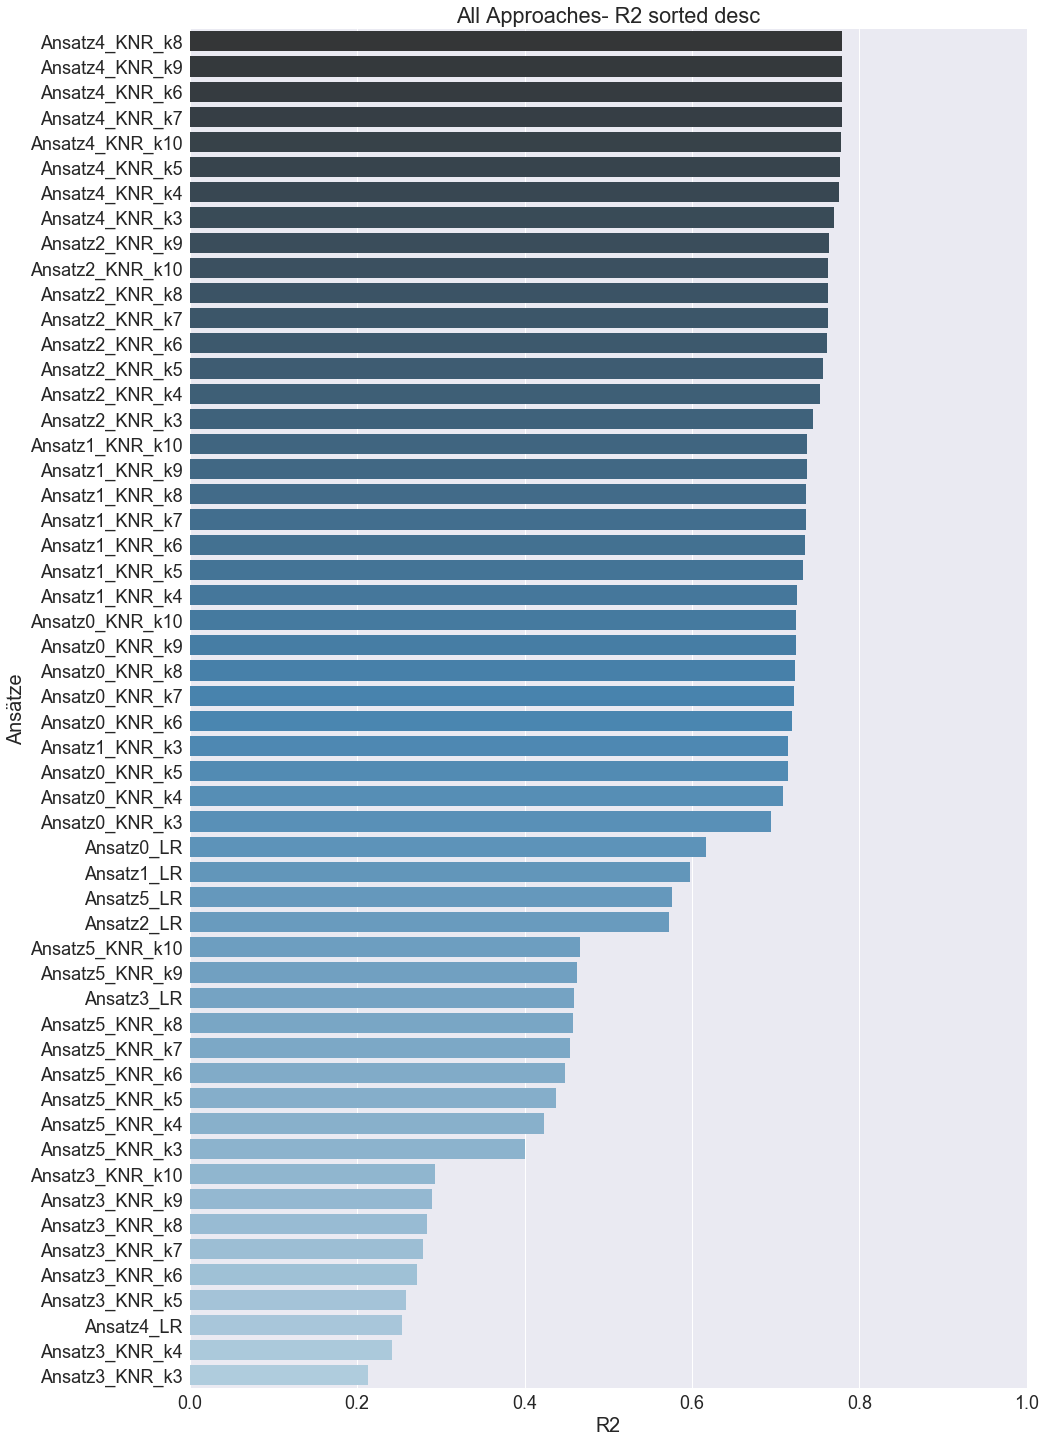

In [41]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15, 25))
sns.set_color_codes("pastel")
g=sns.barplot(x="R2", y=allscoressorted.index,data=allscoressorted,
            label="R2", palette="Blues_d")
g.set(xlim=(0, 1))
g.set(title="All Approaches- R2 sorted desc")
g.set_ylabel("Ansätze")
plt.show()

In [42]:
allscorestop3sorted=allscorestop3.sort_values(by=['R2'],ascending=False)

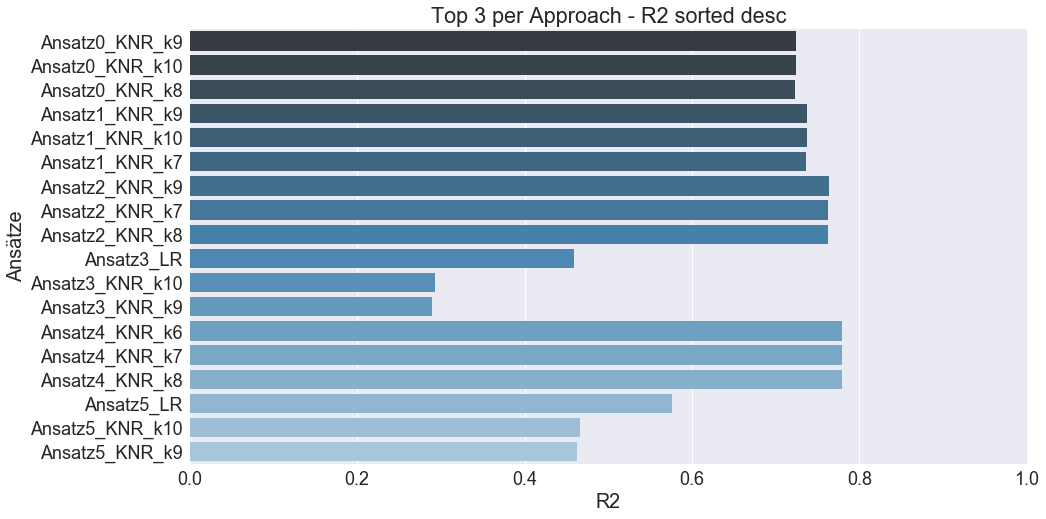

In [43]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15, 8))
sns.set_color_codes("pastel")
h=sns.barplot(x="R2", y=allscorestop3.index,data=allscorestop3,
            label="R2", palette="Blues_d")
h.set(xlim=(0, 1))
h.set(title="Top 3 per Approach - R2 sorted desc")
h.set_ylabel("Ansätze")
plt.show()

In [44]:
features=["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","populations","households","median_income"]
taget=["median_house_value"]

In [45]:
combinations={}

In [46]:
for i in range (2,len(features)+1):
    combinations += itertools.combinations (features,i)

NameError: name 'itertools' is not defined

In [ ]:
for index,features in enumerate (combinations):
    print(index,features, calc(combinations[index]))

In [ ]:
finn na --> mit mean auffüllen 